In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Any results you write to the current directory are saved as output.

In [3]:
filname = '/content/drive/MyDrive/datasetskripsi/fer2013.csv'
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names=['emotion','pixels','usage']
df=pd.read_csv('/content/drive/MyDrive/datasetskripsi/fer2013.csv',names=names, na_filter=False)
im=df['pixels']
df.head(10)

,emotion,pixels,usage
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


In [4]:
def getData(filname):
    # images are 48x48
    # N = 35887
    Y = []
    X = []
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y

In [5]:
X, Y = getData(filname)
num_class = len(set(Y))
print(num_class)

7


In [6]:
N, D = X.shape
X = X.reshape(N, 48, 48, 1)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

In [8]:
pip install --upgrade tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import BatchNormalization


In [10]:
def my_model():
    model = Sequential()
    input_shape = (48,48,1)
    model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    # UNCOMMENT THIS TO VIEW THE ARCHITECTURE
    #model.summary()

    return model
model=my_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       204928    
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 128)       4

In [11]:
path_model = 'model_filter.h5'

# Clear session and set the learning rate
tf.keras.backend.clear_session()
model = my_model()  # create the model
model.optimizer.lr.assign(1e-3)  # set the learning rate

# Fit the model
h = model.fit(x=X_train,
              y=y_train,
              batch_size=64,
              epochs=20,
              verbose=1,
              validation_data=(X_test, y_test),
              shuffle=True,
              callbacks=[
                  ModelCheckpoint(filepath=path_model),
              ]
              )

Epoch 1/20
505/505 [==============================] - 34s 46ms/step - loss: 1.6468 - accuracy: 0.3630 - val_loss: 1.7727 - val_accuracy: 0.3580
Epoch 2/20
  1/505 [..............................] - ETA: 17s - loss: 1.2084 - accuracy: 0.5000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


505/505 [==============================] - 18s 36ms/step - loss: 1.2876 - accuracy: 0.5081 - val_loss: 1.4207 - val_accuracy: 0.4475
Epoch 3/20
505/505 [==============================] - 18s 37ms/step - loss: 1.1202 - accuracy: 0.5774 - val_loss: 1.1999 - val_accuracy: 0.5414
Epoch 4/20
505/505 [==============================] - 19s 37ms/step - loss: 1.0064 - accuracy: 0.6221 - val_loss: 1.1637 - val_accuracy: 0.5620
Epoch 5/20
505/505 [==============================] - 19s 37ms/step - loss: 0.8899 - accuracy: 0.6701 - val_loss: 1.3270 - val_accuracy: 0.5085
Epoch 6/20
505/505 [==============================] - 18s 36ms/step - loss: 0.7560 - accuracy: 0.7225 - val_loss: 1.1577 - val_accuracy: 0.5907
Epoch 7/20
505/505 [==============================] - 18s 36ms/step - loss: 0.6056 - accuracy: 0.7809 - val_loss: 1.2702 - val_accuracy: 0.5860
Epoch 8/20
505/505 [==============================] - 18s 36ms/step - loss: 0.4481 - accuracy: 0.8385 - val_loss: 1.3851 - val_accuracy: 0.6043
Epo

In [12]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
y_pos = np.arange(len(objects))
print(y_pos)

[0 1 2 3 4 5 6]


In [13]:
def emotion_analysis(emotions):
    objects = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, emotions, align='center', alpha=0.9)
    plt.tick_params(axis='x', which='both', pad=10,width=4,length=10)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')

plt.show()

In [14]:
y_pred=model.predict(X_test)
#print(y_pred)
y_test.shape

113/113 [==============================] - 2s 6ms/step


(3589, 7)

In [15]:
#import seaborn as sn
#import pandas as pd
#import matplotlib.pyplot as plt
#import numpy as np
#from sklearn.metrics import confusion_matrix
#%matplotlib inline
#cm = confusion_matrix(np.where(y_test == 1)[1], y_pred)
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#df_cm = pd.DataFrame(cm, index = [i for i in "0123456"],
                  #columns = [i for i in "0123456"])
#plt.figure(figsize = (20,15))
#sn.heatmap(df_cm, annot=True)

1/1 [==============================] - 0s 415ms/step


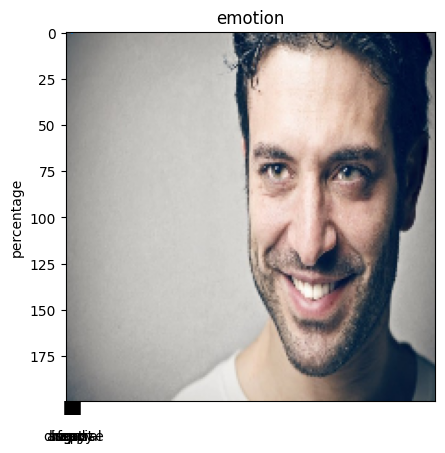

Expression Prediction: happy


In [18]:
from skimage import io
img = image.load_img('/content/SENYUM1.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('/content/SENYUM1.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()
m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i

print('Expression Prediction:',objects[ind])


1/1 [==============================] - 0s 34ms/step


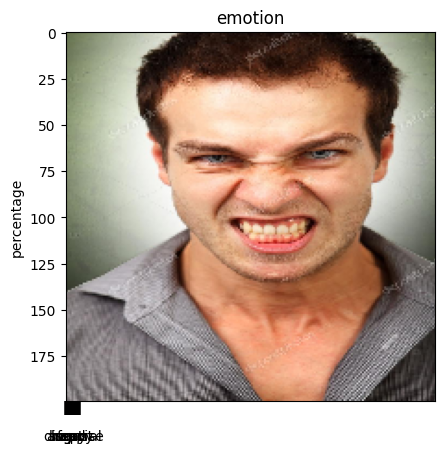

1/1 [==============================] - 0s 36ms/step


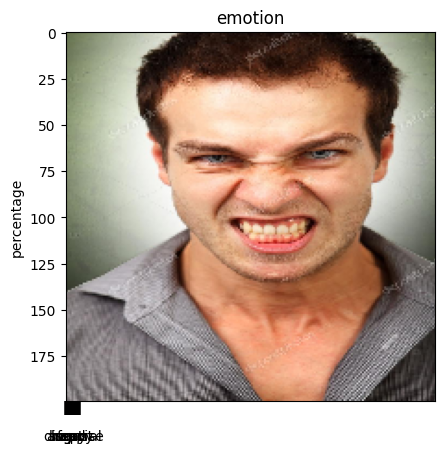

Expression Prediction: angry


In [21]:
from skimage import io
img = image.load_img('/content/marah.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('/content/marah.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        from skimage import io
img = image.load_img('/content/marah.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('/content/marah.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i

print('Expression Prediction:',objects[ind])